In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

train_dir = '/content/drive/My Drive/pothole_data/train'
test_dir = '/content/drive/My Drive/pothole_data/test'
supplementary_dir = '/content/drive/My Drive/pothole_data/supplementary'
csv_dir = '/content/drive/My Drive/pothole_data/'

Mounted at /content/drive


In [ ]:
# Read CSV files
train_labels = pd.read_csv(os.path.join(csv_dir, 'train_labels.csv'))
supplementary_labels = pd.read_csv(os.path.join(csv_dir, 'supplementary_labels.csv'))

train_volumes = pd.read_csv(os.path.join(csv_dir, 'train_volumes.csv'))
supplementary_volumes = pd.read_csv(os.path.join(csv_dir, 'supplementary_volumes.csv'))

# Convert 'Pothole number' column to string for merging and add "p" prefix
train_labels['Pothole number'] = 'p' + train_labels['Pothole number'].astype(str)
supplementary_labels['Pothole number'] = 'p' + supplementary_labels['Pothole number'].astype(str)

# Extract image name without extension and convert to string
train_volumes['Image_Name_No_Ext'] = train_volumes['Image_Name'].str.split('.').str[0].astype(str)
supplementary_volumes['Image_Name_No_Ext'] = supplementary_volumes['Image_Name'].str.split('.').str[0].astype(str)

# Merge label and volume CSVs
train_data = pd.merge(train_labels, train_volumes, left_on='Pothole number', right_on='Image_Name_No_Ext', how='inner')
supplementary_data = pd.merge(supplementary_labels, supplementary_volumes, left_on='Pothole number', right_on='Image_Name_No_Ext', how='inner')

# Combine all data (excluding test data)
unified_data = pd.concat([train_data, supplementary_data], ignore_index=True)

In [ ]:
unified_data

,Pothole number,Bags used,Image_Name,Volume,Image_Name_No_Ext
0,p101,0.5,p101.jpg,7567.50,p101
1,p102,1.0,p102.jpg,8030.37,p102
2,p106,0.5,p106.jpg,7224.28,p106
3,p107,0.5,p107.jpg,188.20,p107
4,p109,0.5,p109.jpg,12927.54,p109
...,...,...,...,...,...
807,p1682,2.0,p1682.jpg,17726.09,p1682
808,p1683,1.5,p1683.jpg,10292.57,p1683
809,p1684,1.0,p1684.jpg,41168.11,p1684
810,p1685,1.5,p1685.jpg,55403.35,p1685


In [ ]:
unified_data.describe()

,Bags used,Volume
count,812.000000,812.000000
mean,0.897906,10237.517599
std,1.137019,16950.313311
min,0.250000,10.090000
25%,0.500000,1684.825000
50%,0.500000,4524.410000
75%,1.000000,10521.505000
max,15.000000,157329.650000


In [ ]:
unified_data.isna().sum()

,0
Pothole number,0
Bags used,0
Image_Name,0
Volume,0
Image_Name_No_Ext,0


In [ ]:
# Function to extract features from the segmented image
def extract_features(image):
    # Resize the image to a smaller size (e.g., 32x32) to reduce complexity
    resized_image = cv2.resize(image, (32, 32))
    # Flatten the image to a 1D array
    flattened_image = resized_image.flatten()
    # Normalize the pixel values
    normalized_image = flattened_image / 255.0
    return normalized_image

In [ ]:
def preprocess_image(image):
    # Step 1: Load the image

    # Step 2: Convert image to HSV format
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Step 3: Create a mask for the green boundary
    lower_green = np.array([35, 100, 100])  # Adjust as needed
    upper_green = np.array([85, 255, 255])  # Adjust as needed
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

    # Step 4: Find contours in the mask
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Assume the largest contour is the boundary
        largest_contour = max(contours, key=cv2.contourArea)

        # Step 5: Create a mask for the inside region
        mask = np.zeros_like(image[:, :, 0])
        cv2.drawContours(mask, [largest_contour], -1, color=255, thickness=cv2.FILLED)

        # Step 6: Extract the region inside the boundary
        segmented_image = cv2.bitwise_and(image, image, mask=mask)

        # Step 7: Crop the image to the bounding box of the contour
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_segment = segmented_image[y:y+h, x:x+w]

        # Normalize the cropped segment if needed
        cropped_segment_gray = cv2.cvtColor(cropped_segment, cv2.COLOR_BGR2GRAY)
        cropped_segment_normalized = cropped_segment_gray / 255.0

        return cropped_segment_normalized

    # If no contours are found, return None
    return None

In [ ]:
# Segment images, extract features, and add them to the dataframe
image_features = []
for index, row in unified_data.iterrows():
    image_path = None
    if row['Image_Name'] in os.listdir(train_dir):
        image_path = os.path.join(train_dir, row['Image_Name'])
    elif row['Image_Name'] in os.listdir(test_dir):
        image_path = os.path.join(test_dir, row['Image_Name'])
    elif row['Image_Name'] in os.listdir(supplementary_dir):
        image_path = os.path.join(supplementary_dir, row['Image_Name'])

    if image_path:
        image = cv2.imread(image_path)
        segmented_image = image  # Replace this with actual segmentation logic if needed
        features = extract_features(segmented_image)
        image_features.append(features)

# Convert list of features to a DataFrame and merge with unified data
features_df = pd.DataFrame(image_features)
unified_dataset = pd.concat([unified_data, features_df], axis=1)

# Drop columns that are no longer needed
unified_dataset = unified_dataset.drop(columns=['Pothole number', 'Image_Name', 'Image_Name_No_Ext'])

# Display the head of the unified dataset
unified_dataset



,Bags used,Volume,0,1,2,3,4,5,6,7,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.5,7567.50,0.447059,0.450980,0.474510,0.650980,0.654902,0.698039,0.749020,0.752941,...,0.662745,0.686275,0.717647,0.772549,0.431373,0.478431,0.521569,0.501961,0.576471,0.580392
1,1.0,8030.37,0.568627,0.615686,0.666667,0.388235,0.411765,0.439216,0.407843,0.431373,...,0.811765,0.439216,0.490196,0.556863,0.286275,0.325490,0.364706,0.498039,0.564706,0.627451
2,0.5,7224.28,0.301961,0.345098,0.384314,0.368627,0.415686,0.486275,0.388235,0.427451,...,0.470588,0.462745,0.529412,0.584314,0.415686,0.474510,0.521569,0.345098,0.423529,0.478431
3,0.5,188.20,0.415686,0.443137,0.478431,0.501961,0.537255,0.576471,0.490196,0.533333,...,0.721569,0.560784,0.627451,0.717647,0.396078,0.435294,0.498039,0.133333,0.137255,0.152941
4,0.5,12927.54,0.694118,0.752941,0.819608,0.639216,0.698039,0.760784,0.650980,0.705882,...,0.498039,0.498039,0.509804,0.541176,0.501961,0.533333,0.560784,0.490196,0.517647,0.552941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,2.0,17726.09,0.188235,0.211765,0.235294,0.670588,0.713725,0.792157,0.552941,0.596078,...,0.815686,0.474510,0.541176,0.600000,0.490196,0.525490,0.600000,0.447059,0.482353,0.521569
808,1.5,10292.57,0.184314,0.203922,0.207843,0.384314,0.415686,0.470588,0.592157,0.643137,...,0.701961,0.576471,0.611765,0.690196,0.462745,0.486275,0.537255,0.725490,0.764706,0.839216
809,1.0,41168.11,0.419608,0.454902,0.505882,0.521569,0.545098,0.588235,0.196078,0.843137,...,0.423529,0.650980,0.682353,0.733333,0.607843,0.619608,0.662745,0.592157,0.607843,0.678431
810,1.5,55403.35,0.380392,0.407843,0.450980,0.376471,0.403922,0.462745,0.458824,0.494118,...,0.729412,0.431373,0.474510,0.560784,0.678431,0.741176,0.796078,0.400000,0.447059,0.517647


In [ ]:
unified_dataset.rename(columns={"Bags used ": "Bags_used"}, inplace=True)

In [ ]:
print(unified_dataset.columns)

Index(['Bags_used',    'Volume',           0,           1,           2,
                 3,           4,           5,           6,           7,
       ...
              3062,        3063,        3064,        3065,        3066,
              3067,        3068,        3069,        3070,        3071],
      dtype='object', length=3074)


In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
# Dropping the outlier data points
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

for col in ["Volume","Bags_used"]:
    unified_dataset = remove_outlier(unified_dataset, col)

In [ ]:
unified_dataset.isna().sum()

,0
Bags_used,0
Volume,0
0,0
1,0
2,0
...,...
3067,0
3068,0
3069,0
3070,0


#modeling

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming `unified_dataset` is the DataFrame from the previous code
X = unified_dataset.drop(columns=['Bags_used']).values
y = unified_dataset['Bags_used'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, PReLU
from tensorflow.keras.regularizers import l2

# Define the model
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    PReLU(),  # Using PReLU activation
    Dropout(0.4),
    Dense(64, kernel_regularizer=l2(0.01)),
    PReLU(),  # Using PReLU activation
    Dropout(0.4),
    Dense(32, kernel_regularizer=l2(0.01)),
    PReLU(),  # Using PReLU activation
    Dropout(0.4),
    Dense(16, kernel_regularizer=l2(0.01)),
    PReLU(),  # Using PReLU activation
    Dense(1)  # Output layer for regression (predicting the number of bags used)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu (PReLU)                      │ (None, 128)                 │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_1 (PReLU)                    │ (None, 64)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_2 (PReLU)                    │ (None, 32)                  │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_3 (PReLU)                    │ (None, 16)                  │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,593 (1.54 MB)

 Trainable params: 404,593 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.25, epochs=100, batch_size=32, verbose=1)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 5.5719 - mae: 1.0318 - val_loss: 4.1262 - val_mae: 0.3423
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.3370 - mae: 0.8644 - val_loss: 4.2473 - val_mae: 0.4344
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.7823 - mae: 0.7269 - val_loss: 4.1618 - val_mae: 0.3936
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.4487 - mae: 0.5926 - val_loss: 4.0672 - val_mae: 0.3449
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.3649 - mae: 0.5332 - val_loss: 4.0135 - val_mae: 0.3434
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.1958 - mae: 0.4686 - val_loss: 3.9590 - val_mae: 0.3474
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.0442 - mae: 0.4404 - val_loss: 3.8984 - val_mae: 0.3532
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.0965 - mae: 0.4628 - val_loss: 3.8227 - val_mae: 0.3427
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - lo

In [ ]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MAE: {test_mae}')

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate additional metrics (if needed)


Test MAE: 0.2382955253124237
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


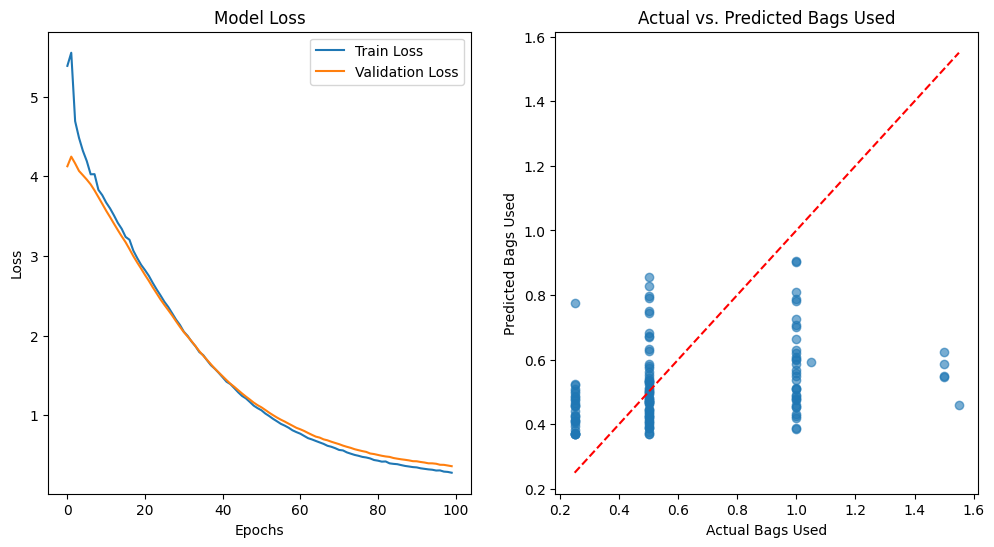

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Scatter plot: Actual vs. Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Bags Used')
plt.ylabel('Predicted Bags Used')
plt.title('Actual vs. Predicted Bags Used')
plt.show()


In [ ]:
# Save the model to a pickle file
import pickle

# Save the model to a pickle file in the specified directory
pickle_path = "/content/drive/My Drive/pothole_data/DNN_model.pkl"
with open(pickle_path, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f"Model saved to '{pickle_path}'")

Model saved to '/content/drive/My Drive/pothole_data/DNN_model.pkl'
